Pubmed

In [ ]:
import requests
import xmltodict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import time

def get_pubmed_papers(query, api_key):
    # Define the search query (e.g., "DNA sequencing")
    max_results = 20  # Number of results to fetch

    # Define the URL for Esearch API (search PubMed)
    url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term={query}&retmax={max_results}&retmode=xml&api_key={api_key}"

    # Send request to PubMed
    response = requests.get(url)

    if response.status_code != 200:
        print("Could not get PMIDS")
        return []

    # Parse the XML response
    search_results = xmltodict.parse(response.content)

    # Extract list of PubMed IDs (PMIDs) from the response
    pmids = search_results['eSearchResult']['IdList']['Id']
    return pmids

# Define a function to fetch details of papers from PubMed

def parse_abstract(abstract):
    if type(abstract) == str: 
        return abstract
    elif type(abstract) == dict:
        return abstract['#text']
    elif type(abstract) == list: 
        abs = ""
        for sec in abstract: 
            abs += sec['#text']
        return abs
    else:
        return "Error"

def fetch_paper_details(pmids, api_key):
    pmid_str = ",".join(pmids)  # Join PMIDs into a comma-separated string
    
    # Define the URL for Efetch API (fetch details by PMIDs)
    url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id={pmid_str}&retmode=xml&api_key={api_key}"
    
    # Send request to PubMed
    response = requests.get(url)

    if response.status_code != 200:
        return pd.DataFrame()
    
    # Parse the XML response
    papers = xmltodict.parse(response.content)['PubmedArticleSet']['PubmedArticle']
    
    # Extract relevant information (title, abstract, authors, etc.)
    paper_details = []
    for idx, paper in enumerate(papers):
        try:
            # Extract title
            title = parse_abstract(paper['MedlineCitation']['Article'].get('ArticleTitle', 'No Title'))
            
            # Extract abstract
            abstract = paper['MedlineCitation']['Article'].get('Abstract', {}).get('AbstractText', '')
            parsed_abstract = parse_abstract(abstract)
            
            # Extract publication date
            pub_date = paper['MedlineCitation']['Article']['Journal']['JournalIssue'].get('PubDate', {})
            year = pub_date.get('Year', '')
            month = pub_date.get('Month', '')
            published = f"{year}-{month}".strip('-')
            
            # Extract PMID as ID
            pmid = paper['MedlineCitation']['PMID']['#text']
            
            # Standardize output to match arXiv function
            paper_details.append({
                "id": pmid,  # Matches arXiv's "id" column
                "title": title.strip(),
                "summary": parsed_abstract.strip(),
                "published": published,
                "sourced_from": "PubMed",  # Added to match arXiv's structure
                "query": "telomeres" 
            })
        except Exception as e:
            print(f"Error processing paper: {e} at {idx}")
    
    return pd.DataFrame(paper_details)

load_dotenv()
api_key = os.getenv("pubmed_key")
pmids = get_pubmed_papers("telomeres", api_key)
papers_data = fetch_paper_details(pmids, api_key)
df = pd.concat([pd.DataFrame(), papers_data], ignore_index=True)
df.to_json('papers.json', orient='records', lines=True)

arXiv

In [53]:
import requests
import xmltodict
import pandas as pd

def fetch_arxiv_papers(query="all", max_results=50):
    """
    Fetches papers from arXiv based on a query.
    
    Args:
        query (str): Search term or category.
        max_results (int): Number of papers to retrieve.
        
    Returns:
        DataFrame: Contains titles, abstracts, and arXiv IDs.
    """
    base_url = "http://export.arxiv.org/api/query?"
    url = f"{base_url}search_query={query}&start=0&max_results={max_results}"

    response = requests.get(url)
    if response.status_code != 200:
        return pd.DataFrame()

    data = xmltodict.parse(response.content)
    if 'entry' not in data['feed']:
        return pd.DataFrame()
    entries = data['feed']['entry']
    
    # Parse entries into a DataFrame
    papers = []
    for entry in entries:
        papers.append({
            "id": entry["id"],
            "title": entry["title"].strip(),
            "summary": entry["summary"].strip(),
            "published": entry["published"],
            "sourced_from": "arXiv",
            "query": query
        })

    return pd.DataFrame(papers)

# Example Usage

queries = ['machine learning', '3D computer vision', 'DNA', 'Nuclear Theory', 'sentiment analysis', 'black holes', 'hydropower'] 

df = pd.DataFrame()

for query in queries: 
    papers_df = fetch_arxiv_papers(query=query, max_results=40)
    if len(papers_df) == 0:
        break
    df = pd.concat([df, papers_df], ignore_index=True)

In [55]:
df = pd.concat([df, pd.DataFrame(papers_data)], ignore_index=True)

In [2]:
def get_paper_citations(arxiv_id):
    """
    Fetches the citation count for a paper from Semantic Scholar using the arXiv ID.
    
    Args:
        arxiv_id (str): The arXiv ID of the paper (e.g., "2103.00020").
        
    Returns:
        int: Citation count, or None if not found.
    """
    url = f"https://api.semanticscholar.org/v1/paper/arXiv:{arxiv_id}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return data.get("numCitedBy", 0)
    else:
        return None

# Example usage
arxiv_id = "1706.03762"  # Replace with a valid arXiv ID
citation_count = get_paper_citations(arxiv_id)
print(f"Paper {arxiv_id} has {citation_count} citations.")


Paper 1706.03762 has 112066 citations.


In [57]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Small, fast model for semantic embeddings

# Prepare the text: combine titles and abstracts
df['text'] = df['title'] + ". " + df['summary']

# Generate embeddings
embeddings = model.encode(df['text'].tolist(), show_progress_bar=True)

# Save embeddings as a NumPy array
embeddings = np.array(embeddings)
print(f"Generated embeddings shape: {embeddings.shape}")

Batches: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

Generated embeddings shape: (121, 384)


Visualize with PCA

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer

# Standardize the embeddings before PCA (important for better results)
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Perform PCA to reduce to 2D or 3D
pca = PCA(n_components=2)  # For 2D visualization, change to 3 for 3D
pca_result = pca.fit_transform(embeddings_scaled)

# Add the PCA results to your DataFrame for easier visualization
df['PCA_x'] = pca_result[:, 0]
df['PCA_y'] = pca_result[:, 1]

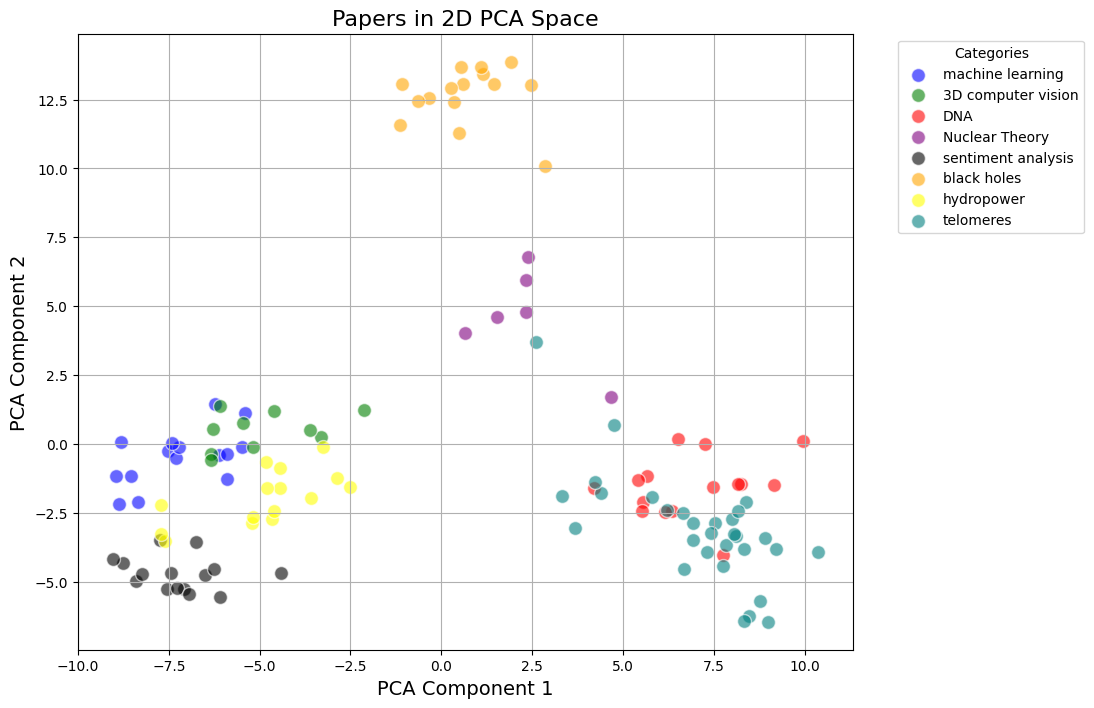

In [59]:
# Define a color map based on categories
category_colors = {
    'machine learning': 'blue',
    '3D computer vision': 'green',
    'DNA': 'red',
    'Nuclear Theory': 'purple',
    'sentiment analysis': 'black',
    'black holes': 'orange', 
    'hydropower': 'yellow',
    'telomeres': 'teal'
}


# Plot the papers on a 2D scatter plot
plt.figure(figsize=(10, 8))
for category in df['query'].unique():
    category_data = df[df['query'] == category]
    plt.scatter(category_data['PCA_x'], category_data['PCA_y'], 
                label=category, color=category_colors.get(category, 'gray'), alpha=0.6, edgecolors='w', s=100)

# Add labels and title
plt.title("Papers in 2D PCA Space", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=14)
plt.ylabel("PCA Component 2", fontsize=14)
plt.legend(title="Categories", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


Find Papers + Extract Answers

In [72]:
from sklearn.metrics.pairwise import cosine_similarity

def search_papers(query, model, embeddings, metadata, top_k=5):
    """
    Search for similar papers using cosine similarity.
    
    Args:
        query (str): Search query text.
        model: Sentence-BERT model for embeddings.
        embeddings: Precomputed paper embeddings.
        metadata: Paper metadata DataFrame.
        top_k (int): Number of top results to return.
    """
    # Encode the query into the same space
    query_embedding = model.encode([query])
    
    # Compute cosine similarity
    similarities = cosine_similarity(query_embedding, embeddings)[0]
    top_indices = similarities.argsort()[-top_k:][::-1]
    
    # Display top results
    papers = []
    for idx in top_indices:
        print(metadata.iloc[idx]['title'])
        papers.append(metadata.iloc[idx]['summary'])
    print('----')
    return papers

In [84]:
def extract_answer(question, context, min_answer_length=5):
    """
    Extract the most likely answer from a given context with improved handling of longer texts.
    
    Args:
        question (str): Question to answer
        context (str): Context text to extract answer from
        min_answer_length (int): Minimum length of acceptable answer
    
    Returns:
        str: Extracted answer or None
    """
    # Use sliding window approach for longer contexts
    max_length = 512
    stride = 256  # Overlap between windows

    # Tokenize the full context
    full_encoding = qa_tokenizer.encode_plus(
        question, 
        context, 
        return_tensors="pt", 
        max_length=max_length, 
        truncation=True, 
        return_overflowing_tokens=True,
        stride=stride
    )

    best_answer = None
    best_score = -float('inf')

    # Iterate through possible windows
    for i in range(len(full_encoding['input_ids'])):
        try:
            # Prepare inputs for this window
            inputs = {
                'input_ids': full_encoding['input_ids'][i].unsqueeze(0),
                'attention_mask': full_encoding['attention_mask'][i].unsqueeze(0)
            }
            
            # Get model outputs
            with torch.no_grad():
                outputs = qa_model(**inputs)
            
            # Extract answer
            start_scores = outputs.start_logits
            end_scores = outputs.end_logits
            
            # Compute overall answer score
            max_score = start_scores.max().item() + end_scores.max().item()
            
            # Find the most likely start and end positions
            start_index = torch.argmax(start_scores)
            end_index = torch.argmax(end_scores)
            
            # Ensure start index is before or equal to end index
            if start_index <= end_index:
                # Decode the answer tokens
                answer_tokens = inputs['input_ids'][0][start_index:end_index+1]
                answer = qa_tokenizer.decode(answer_tokens)
                
                # Clean and filter the answer
                answer = answer.strip()
                
                # Additional filtering
                if (len(answer) >= min_answer_length and 
                    answer.lower() not in ['<s>', '</s>', 'none', 'n/a'] and
                    not answer.isspace()):
                    
                    # Keep track of the best answer
                    if max_score > best_score:
                        best_answer = answer
                        best_score = max_score
        
        except Exception as e:
            print(f"Error processing window {i}: {e}")
    print(best_answer)
    return best_answer

def generate_comprehensive_answer(query, papers):
    """
    Generate a comprehensive answer by combining insights from multiple papers.
    
    Args:
        query (str): Original question
        papers (list): List of paper summaries
    
    Returns:
        str: Synthesized comprehensive answer
    """
    answers = []
    
    for summary in papers:
        try:
            ans = extract_answer(query, summary)
            if ans:
                answers.append(ans)
        except Exception as e:
            print(f"Error extracting answer: {e}")
    
    # Deduplicate and combine answers
    unique_answers = list(set(answers))
    
    if unique_answers:
        # Join unique answers
        comprehensive_answer = " ".join(unique_answers)
        return comprehensive_answer
    else:
        return "I couldn't find a definitive answer in the retrieved papers."

# Example usage
query = "How do telomeres affect cardiovasular health?"
papers = search_papers(query, model, embeddings, df, top_k=3)

# Generate and print comprehensive answer
comprehensive_answer = generate_comprehensive_answer(query, papers)
print("Comprehensive Answer:", comprehensive_answer)

The association between short telomere length and cardiovascular disease.
Association Between Maternal Prepregnancy and Pregnancy Body Mass Index and Children's Telomere Length: A Systematic Review and Meta-analysis.
Association of early-life factors with biological age acceleration and the mediating effect of social environment risks in middle-aged and older adults.
----
shorten with cell division, countered by telomerase. Short telomeres are linked to cardiovascular disease (CVD), alongside its risk factors like aging, hypertension, diabetes, obesity, inactivity, and smoking. Many studies have claimed the implication of TL in cardiac diseases. This study examines telomere length's (TL) impact on heart conditions
aging
None
Comprehensive Answer: aging shorten with cell division, countered by telomerase. Short telomeres are linked to cardiovascular disease (CVD), alongside its risk factors like aging, hypertension, diabetes, obesity, inactivity, and smoking. Many studies have claimed t